In [7]:

import os
import sys
import subprocess
# sys.path.insert(1, f"{subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')}/logistics/tools")
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools
import numpy as np
import openmc
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
# from tools import image_to_thesis
# image_to_thesis.pull_from_thesis()


100%|██████████| 1000/1000 [00:05<00:00, 190.64it/s]


Text(0.5, 1.0, 'Sampled F19 cross section')

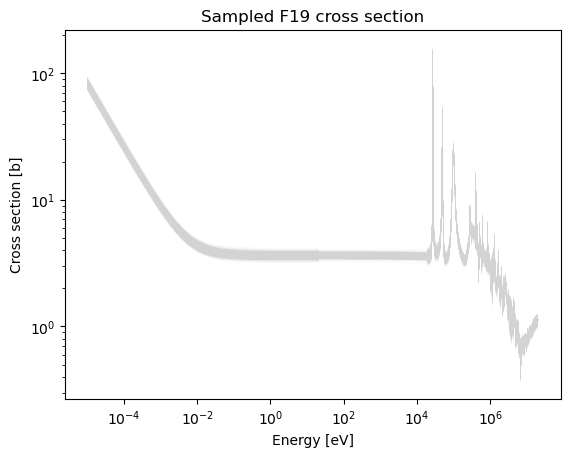

In [30]:
sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v1/hdf5/F19"

fig = plt.figure()
ax = fig.gca()

TEMPERATURE = 900 # K

N_ITERATIONS = 1000
for i in tqdm(range(N_ITERATIONS)):
    h5_filename = f"{sampled_h5_files_path}/F19-{i+1}.h5"

    h5file = h5py.File(h5_filename, 'r')
    energy_group = h5file[f'F19/energy/{TEMPERATURE}K']
    reactions_group = h5file[f'F19/reactions']
    # for name, obj in sorted(list(main_group.items()))[:10]:
    #     if 'reaction_' in name:
    #         print('{}, {}'.format(name, obj.attrs['label'].decode()))

    n_elastic_xs_group = reactions_group[f'reaction_002/{TEMPERATURE}K/xs']
    # print(list(n_elastic_group.values()))

    # Extract the cross section and energy data
    energy = energy_group[:]
    xs = n_elastic_xs_group[:]


    # F19_reconstructed = openmc.data.IncidentNeutron.from_hdf5(h5_filename)

    # Plot the sampled cross section
    ax.loglog(energy, xs, label="Sampled", color="lightgrey", linewidth=0.02)

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Cross section [b]")
ax.set_title("Sampled F19 cross section")

    